In [1]:
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from scipy import integrate, interpolate  
from scipy.stats import gengamma, laplace, norm
from scipy.stats import kstwobign, kstest, ks_1samp, anderson, anderson_ksamp, cramervonmises, kstwo, ksone
from scipy.special import kolmogorov
import matplotlib.pyplot as plt
from utilities import *
%matplotlib inline
import pickle
from ipywidgets import interactive

np.random.seed(42)

### Complete Prior Model for Signal $x$

400


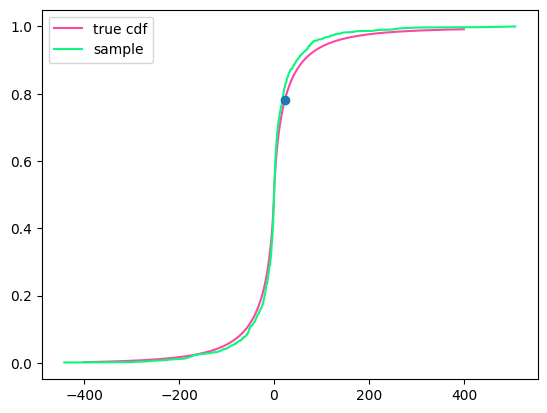

In [2]:
xs = np.linspace(-400, 400, 1000)
n = 1000
sample = sorted(sample_prior(0.4, 0.0001, n))
cdf = compute_prior_cdf(0.4, 0.2, x_interval = 400)
plt.plot(xs, cdf(xs), label = 'true cdf', color = 'xkcd:barbie pink')
sns.lineplot(x = sample, y = np.arange(1, n+1)/n, label = 'sample', color = 'xkcd:minty green')
kstest_res = ks_1samp(sample, cdf)
plt.plot(kstest_res.statistic_location, cdf(kstest_res.statistic_location), marker='o', alpha = 0.4)

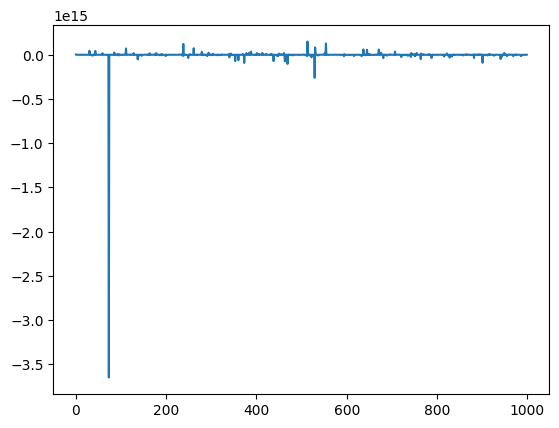

In [3]:
plt.plot(sample_prior(0.1, 0.000001, 1000))

Text(0.5, 1.0, '(r, eta) pairs for which CDFS are computed')

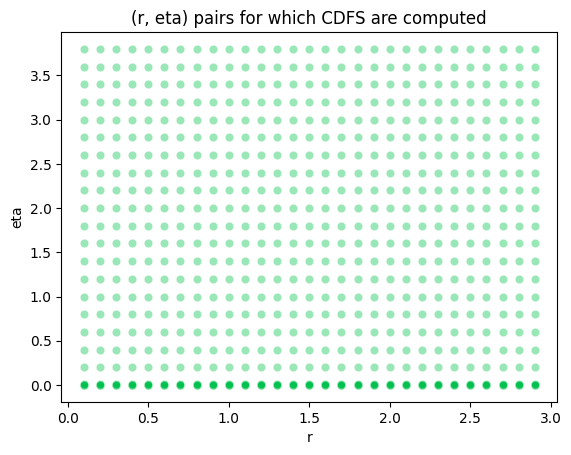

In [50]:
with open('updated_100000.pickle', 'rb') as handle:
    all_cdfs = pickle.load(handle)
all_keys = np.array(list(all_cdfs.keys()))
all_cdfs_df = pd.DataFrame(all_cdfs.items())
all_cdfs_df['r'] = pd.Series(all_cdfs_df[0])
all_cdfs_df['eta'] = pd.Series(all_cdfs_df[0])
sns.scatterplot(x = all_keys.T[0], y = all_keys.T[1], color = 'xkcd:shamrock green', alpha = 0.4)
plt.xlabel('r')
plt.ylabel('eta')
plt.title('(r, eta) pairs for which CDFS are computed')

## KS-Test in the Limit

In [5]:
pvals_df = pd.DataFrame(columns = ['n', 'alpha', 'distance'])
alphas = np.arange(0.01, 0.25, 0.01)#np.array([0.10, 0.05, 0.01])
num_samples = np.arange(1, 7)
i = 0
for n in 10**num_samples:
    for a in alphas:
        pvals_df.loc[i, :] = (n, a, kstwo(n=n).isf(a))
        i += 1
pvals_df.head(10)

,n,alpha,distance
0,10,0.01,0.488932
1,10,0.02,0.456624
2,10,0.03,0.436386
3,10,0.04,0.42135
4,10,0.05,0.409246
5,10,0.06,0.399035
6,10,0.07,0.390153
7,10,0.08,0.382263
8,10,0.09,0.37515
9,10,0.1,0.368662


In [6]:
np.round((kstwo(n=100).isf(0.05), kstwo(n=1000).isf(0.05), kstwo(n=100).isf(0.1)), 4)
# With 100 samples, if we fix probability of incorrecting rejecting the null hypothesis to be 0.05, our cutoff for distances is 0.134
# That is, if the ECDF differs from the true CDF by more than 0.134, only then do we reject the null hypothesis
# As expected, if our sample size increases, then we can decrease our distance cutoff (0.134 -> 0.0428)
# i.e. our rejection region is larger to achieve the same level - our test is more discriminative
# If instead, we keep number of samples fixed, but increase our level (we are okay with rejecting our null hypothesis with probability 0.1),
# the cutoff becomes slightly lower (0.134 -> 0.1207)

array([0.134 , 0.0428, 0.1207])

0.36900000000000027

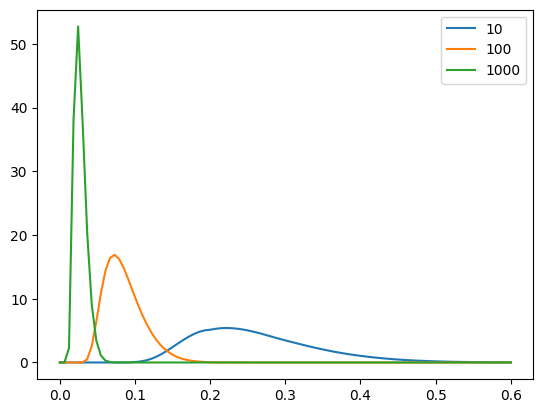

In [51]:
xs = np.linspace(0, 0.6, 100)
plt.plot(xs, kstwo(n=10).pdf(xs), label = '10')
plt.plot(xs, kstwo(n=100).pdf(xs), label = '100')
plt.plot(xs, kstwo(n=1000).pdf(xs), label = '1000')
plt.legend()
kstwo(n=10).isf(1 - kstwo(n=10).cdf(0.369))

Text(0.5, 0, 'log10 number of samples')

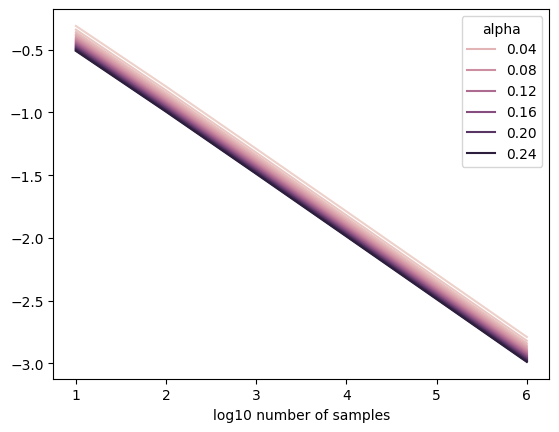

In [54]:
sns.lineplot(x = np.log10(pvals_df['n'].tolist()), y = np.log10(pvals_df['distance'].tolist()), hue = pvals_df['alpha'])
plt.xlabel('log10 number of samples')

In [10]:
%%time
# Assuming I had both true distributions, but was uisng Kolmorogov with n samples
xs = np.linspace(-200, 200, 100000)
all_keys = list(all_cdfs.keys())[::4]
num_samples = 10**np.arange(1,5)
num_samples_names = list(num_samples)
all_dist_df = pd.DataFrame(columns = ['base_r', 'base_eta', 'r', 'eta', 'distance'] + num_samples_names)
with open('all_dist_df.pickle', 'rb') as handle:
    all_dist_df = pickle.load(handle)
done = set()

for i, (base_r, base_eta) in enumerate(all_keys):
    base_cdf = all_cdfs[(base_r, base_eta)](xs)
    #print(i)
    for j, (r, eta) in enumerate(all_keys):
        row = (min(base_r, r), min(base_eta, eta), max(base_r, r), max(base_eta, eta))
        if row not in done:
            cdfvals = all_cdfs[(r, eta)](xs)
            distance = np.max(np.abs(cdfvals - base_cdf))
            pvals = [ksone(n=i).sf(distance) for i in num_samples]
            all_dist_df.loc[i*len(all_cdfs)+j, :] = [base_r, base_eta, r, eta, distance] + pvals
            all_dist_df.loc[i*len(all_cdfs)+j, :] = [r, eta, base_r, base_eta, distance] + pvals
            done.add((min(base_r, r), min(base_eta, eta), max(base_r, r), max(base_eta, eta)))
print(all_dist_df.shape)
all_dist_df.head()
# with open(f'all_dist_df.pickle', 'wb') as handle:
#     pickle.dump(all_dist_df, handle, protocol=pickle.HIGHEST_PROTOCOL) 

(10584, 9)
CPU times: total: 1min 35s
Wall time: 3min 40s


,base_r,base_eta,r,eta,distance,10,100,1000,10000
0,0.1,0,0.1,0,0.0,1.0,1.0,1.0,1.0
1,0.1,0.8,0.1,0,0.0,1.0,1.0,1.0,1.0
2,0.1,1.6,0.1,0,0.0,1.0,1.0,1.0,1.0
3,0.1,2.4,0.1,0,0.0,1.0,1.0,1.0,1.0
4,0.1,3.2,0.1,0,0.0,1.0,1.0,1.0,1.0


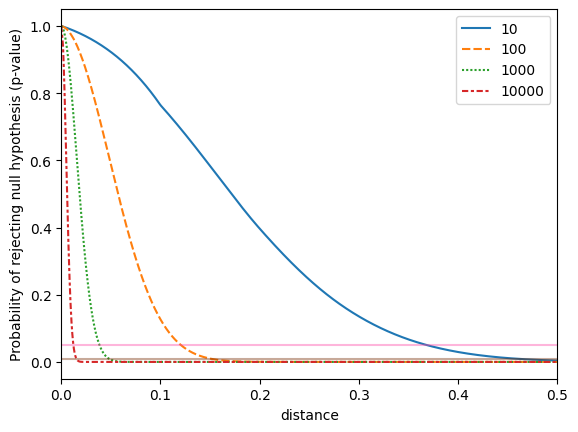

In [15]:
sns.lineplot(data = all_dist_df[all_dist_df.columns[4:]].set_index('distance'))
plt.axhline(y=0.05, color='xkcd:barbie pink', label='0.05', alpha = 0.4)
plt.axhline(y=0.01, color='xkcd:chestnut', label='0.01', alpha = 0.4)
plt.ylabel('Probability of rejecting null hypothesis (p-value)')
plt.xlim((0, 0.5))
all_dist_df[all_dist_df.columns[4:]].set_index('distance')
#plt.savefig('pvalues_distances_over_num_samples.png', dpi = 600, bbox_inches = 'tight')

## Single Distribution Visualizations

In [33]:
# SPECIFY PARAMETERS
base_r = 0.8
base_eta = 0.00001
eps_r = 5
eps_eta = 5
skip = 1
xs = np.linspace(-200, 200, 100000)

single_dist_df = all_dist_df[(all_dist_df['base_r'] == base_r) & (all_dist_df['base_eta'] == base_eta)].drop(['base_r', 'base_eta'], axis = 1)
param_neighbors = (single_dist_df['r'] <= (base_r + eps_r)) & (single_dist_df['r'] >= (base_r - eps_r)) & (single_dist_df['eta'] >= base_eta - eps_eta) & (single_dist_df['eta'] <= base_eta + eps_eta)
param_spread = single_dist_df.index%skip == 0
single_dist_df = single_dist_df[param_spread & param_neighbors]
single_dist_df.head(10)

,r,eta,distance,10,100,1000,10000
55,0.1,0,1.045004,0.0,0.0,0.0,0.0
811,0.1,0.8,1.045004,0.0,0.0,0.0,0.0
1567,0.1,1.6,1.045004,0.0,0.0,0.0,0.0
2323,0.1,2.4,1.045004,0.0,0.0,0.0,0.0
3079,0.1,3.2,1.045004,0.0,0.0,0.0,0.0
3835,0.1,0.0,1.045004,0.0,0.0,0.0,0.0
4591,0.1,0.00001,1.045004,0.0,0.0,0.0,0.0
5347,0.2,0,0.993817,0.0,0.0,0.0,0.0
6103,0.2,0.8,1.04132,0.0,0.0,0.0,0.0
6859,0.2,1.6,1.045004,0.0,0.0,0.0,0.0


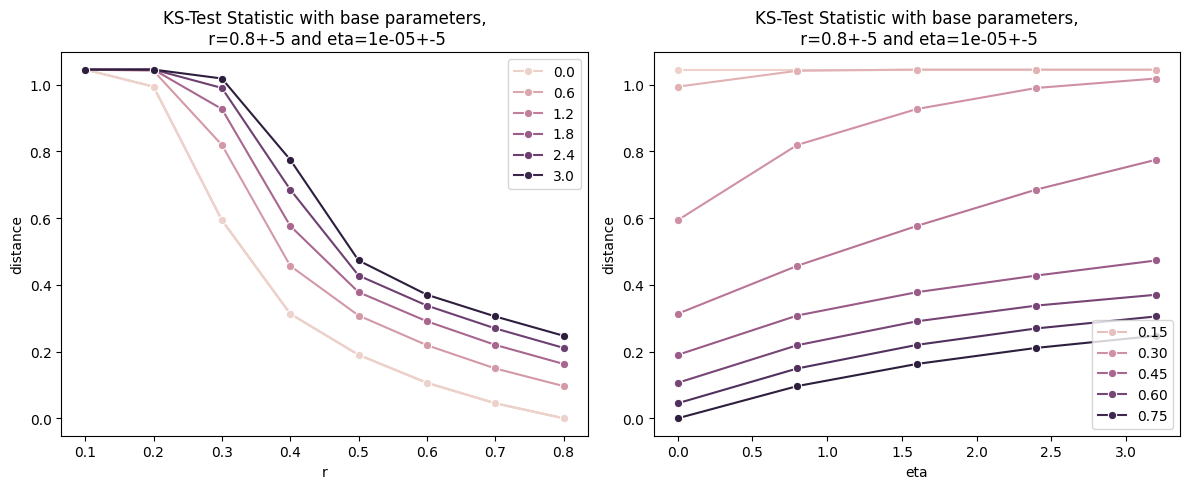

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# First plot
sns.lineplot(data=single_dist_df, x='r', y='distance', hue='eta', marker='o', ax=ax1)
ax1.set_title(f'KS-Test Statistic with base parameters,\n r={base_r}+-{eps_r} and eta={base_eta}+-{eps_eta}')
ax1.legend()

# Second plot
sns.lineplot(data=single_dist_df, x='eta', y='distance', hue='r', marker='o', ax=ax2)
ax2.set_title(f'KS-Test Statistic with base parameters,\n r={base_r}+-{eps_r} and eta={base_eta}+-{eps_eta}')
ax2.legend()

plt.tight_layout()
plt.savefig(f'images/pvalues_base_({base_r},{base_eta}).png', dpi=300, bbox_inches='tight')
plt.show()

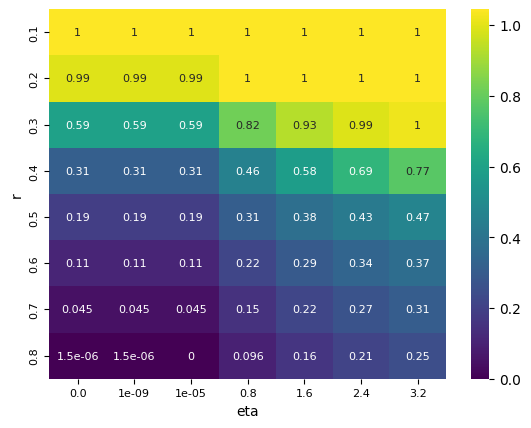

In [35]:
sns.heatmap(single_dist_df
            .pivot_table(index = 'r', columns = 'eta', values = 'distance')
            .astype('float'), annot=True, annot_kws={'fontsize': 8}, cmap='viridis');
plt.xticks(fontsize = 8);
plt.yticks(fontsize = 8);
plt.savefig(f'images/heatmap_base_({base_r},{base_eta})_eta.png', dpi = 300, bbox_inches = 'tight')

## Tiled heatmaps

In [38]:
all_dist_df['r'].unique(), all_dist_df['eta'].unique()

(array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3,
        1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
        2.7], dtype=object),
 array([0, 0.8, 1.6, 2.4, 3.2, 1e-09, 1e-05], dtype=object))

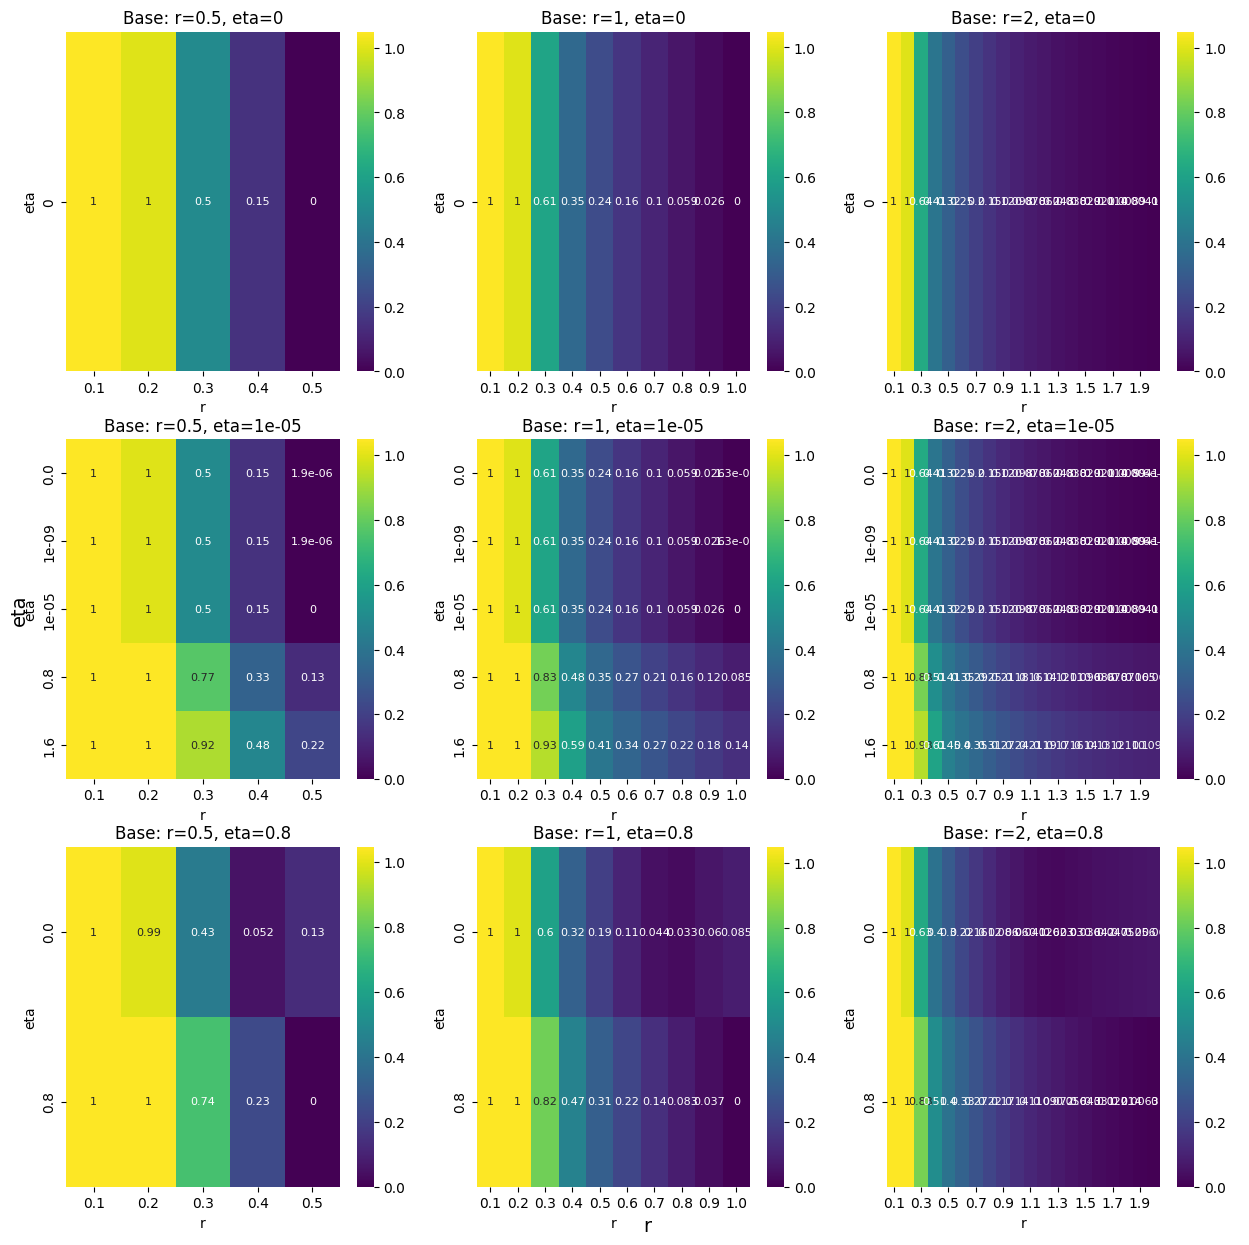

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the base r and eta values
base_r_values = [0.5, 1, 2]
base_eta_values = [0, 1e-05, 0.8]

# Define the hyperparameters
eps_r = 2
eps_eta = 2

# Create a figure with subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Iterate over the subplots and create heatmaps
for i, base_eta in enumerate(base_eta_values):
    for j, base_r in enumerate(base_r_values):
        ax = axs[i, j]
        heatmap_data = all_dist_df.loc[
            (all_dist_df['base_r'] == base_r) &
            (all_dist_df['base_eta'] == base_eta) &
            (np.abs(all_dist_df['r'] - base_r) <= eps_r) &
            (np.abs(all_dist_df['eta'] - base_eta) <= eps_eta),
            ['r', 'eta', 'distance']
        ].pivot_table(index='eta', columns='r', values='distance')
        heatmap_data = heatmap_data.astype('float')

        sns.heatmap(heatmap_data, annot=True, annot_kws={'fontsize': 8}, cmap='viridis', ax=ax)
        ax.set_title(f'Base: r={base_r}, eta={base_eta}', fontsize=12)
        ax.set_xlabel('r', fontsize=10)
        ax.set_ylabel('eta', fontsize=10)

# Add a set of axes outside the tiles
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("r", fontsize=14)
plt.ylabel("eta", fontsize=14)

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.2, hspace=0.2)

# Show the plot
plt.show()


### Summary takeaways

For $r$ small (< 1), test statistic can distinguish between right $r$ and wrong $r$ well. (e.g. $r=0.5, \eta = 0.1$). $\eta$ values as far upto 0.5 away from the true value are not identifiable with the test when the $r$ value is fixed. When $\eta$ is fixed, the test will be right for $\eta$ plus or minus 0.3 

For $1 <= r <= 2$, test statistic is weaker and a wider range of $\eta$ values have distance <= 0.5. For bigger $r$, the distances are much closer for a wider range of values of both $r$ and $\eta$.

As $\eta$ values increase with fixed $r >=1$, the distance between l 

Interesting cases:
1. Base (r, eta) = (0.75, 0.1). (1, 0.7) falls below 0.05 threshold, but previous points do not

## Significance

In [ ]:
ks_1samp(sample_prior(1.1, 0.01, 10), cdf=compute_prior_cdf(1.2, 0.01))

20.0


KstestResult(statistic=0.39060680701386263, pvalue=0.06945776537513293, statistic_location=1.3708705455407313, statistic_sign=-1)

In [ ]:
p_vals = np.array([])
REPETITIONS = 10
for n in np.arange(REPETITIONS):
    p_vals = np.append(p_vals, ks_1samp(sample_prior(1.1, 0.01, 100), cdf=compute_prior_cdf(1.3, 0.01)).pvalue)

np.mean(p_vals)

19.0
19.0
19.0
19.0
19.0
19.0
19.0
19.0
19.0
19.0


0.338080037128658

## Power

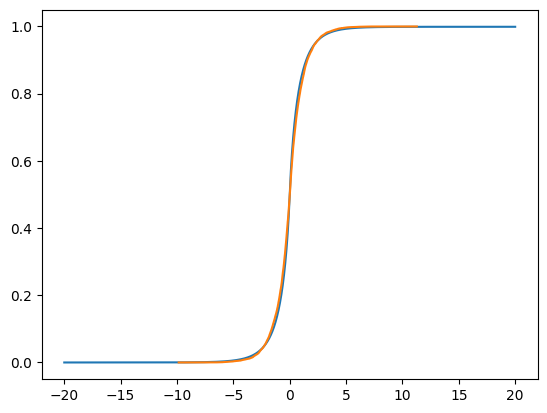

In [ ]:
n = 10000
xs = np.linspace(-20, 20, n)
plt.plot(xs, compute_prior_cdf(1.2, 0.01)(xs))
plt.plot(sorted(sample_laplace(n)), np.arange(n)/n)

In [ ]:
ks_1samp(sample_laplace(1000), cdf=compute_prior_cdf(1.2, 0.01))

KstestResult(statistic=0.0663522652531432, pvalue=0.00028498781597315114, statistic_location=-0.3935478087389785, statistic_sign=1)

In [ ]:
cramervonmises(sample_laplace(1000), cdf=compute_prior_cdf(1.2, 0.01))

CramerVonMisesResult(statistic=0.8743888965437387, pvalue=0.0048538974402172474)